## Process Data


### Import Nescessary Library

In [ ]:
# import json to read a json file
import json
import data_utils as dt #Read Json file and create diction of text and markup
import string
import math
import nltk
from difflib import SequenceMatcher 
import matplotlib.pyplot as plt

#import seaborn as sns

### Read the data

In [ ]:
# Data is a list of dictionaries of text and its markup
data = dt.process_data('Data/tai-documents-v3/tai-documents-v3.json')

In [ ]:
len(data)

In [ ]:
type(data)

In [ ]:
type(data[0])

In [ ]:
data[0].keys()

### A example of markup

In [ ]:
data[0]['markup']

In [ ]:
type(data[0])

## Process each essay and find similar error

### Word Choice

In [ ]:
# input: and essay with plain_text and markup
# output: return a list of similar errors of word_choice with number of error for each
# The related words for that error and the indices (on markup) of that error
def word_choice(input):
    output = []
    check = False
    for i in range(len(input['markup'])):
        error = input['markup'][i]
        check = False
        if error['type'] == 'word choice':
            # Check if we see this error before, update the error_count
            for item in output:
                if ((error['old_text'] in item['words']) or
                   (error['new_text'] in item['words'])):
                        check = True # Set this error already marked
                        item['index'].append(i)                          
                        item['words'].add(error['old_text'])
                        if error['new_text'] != None and error['new_text'] != '':
                            item['words'].add(error['new_text'])
                        item['error_count'] = item['error_count'] + 1
            
            # The error haven't been seen before
            if check == False:
                if error['new_text'] != None: 
                    output.append({'words' : {error['old_text'], error['new_text']}, 
                               'index' : [i], 'error_count' : 1})
                else: 
                    output.append({'words' : {error['old_text']}, 
                               'index' : [i], 'error_count' : 1})
                
                
    # Return output
    return output          

The common spelling errors among the whole data set is
sta ['star', 'star', 'staff', 'staff']
yor ['your', 'your', 'your', 'your']
the ['they', 'they', 'they', 'they']


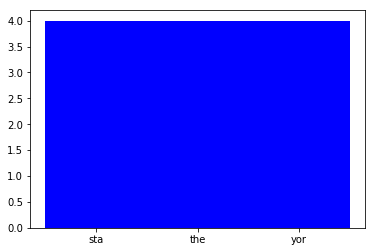

152


In [210]:
def sub(str1,str2): 
    seqMatch = SequenceMatcher(None,str1,str2) 
    match = seqMatch.find_longest_match(0, len(str1), 0, len(str2)) 
    if (match.size!=0):
        z=str1[match.a: match.a + match.size]
        return z
    
def de(str1,str2,str3):
    a=dict()
    c=None
    for i in str1:
        for j in str2:
            if(i==j and str1.index(i)==str2.index(j)):
                c=str1.replace(i,'')
            
                
    if c==None:
        return
    if c not in a.keys():
        a[c]=[str1,str3]
    else:
        a[c]=a[c]+[str1,str3]
    return a
	
def spel(i):
    a=[error['old_text'] for error in data[i]['markup'] if error['type'] == 'spelling']
    b=[error['new_text'] for error in data[i]['markup'] if error['type'] == 'spelling']
    co=0
    e=dict()
    for i in range(0,len(a)-1):
        for j in range(i,len(a)-1):
            if i!=j:
                c=sub(a[i],a[j])
                if(c!=None and len(c)>3 and b[j]!=None):
                    d=de(a[j],b[j],a[i])
                    if(d is not None):
                        for k in d.keys():
                            e[k]=d[k]
    if e!=None:
        r1=0
        g=dict()
        for i in e.keys():
            if len(e[i])>1:
                g[i]=len(e[i])
                r1=r1+len(e[i])

        #print("common error patterns",end=' ')
        #print([i for i in e.keys() if len(e[i])>1])
        #print("common error words", end=' ')
        #print([v for v in e.values() if len(e[i])>1] )


        #print("percentage of common errors:",end=' ')
        #if(len(a)!=0):
         #   print((r1*100)/len(a))
        #else:
         #   print("No spelling errors found")

        #plt.bar(g.keys(), g.values(), 1, color='g')
        #plt.show()
        return e
def act():
    f=dict()
    m,k=0,0
    for i in range(0,209):
        e=spel(i)
        if e is not None:
            for i in e.keys():
                if i not in f.keys():
                    f[i]=e[i]
                    k=k+len(e[i])
                else:
                    f[i]=f[i]+e[i]
                    k=k+len(e[i])
                    
    c=[(len(f[i]),i) for i in f.keys() if len(f[i])>2]
    print("The common spelling errors among the whole data set is")
    h=dict()
    for i in c:
        h[i[1]]=len(f[i[1]])
        print(i[1],f[i[1]])
    plt.bar(h.keys(),h.values(),1, color='b')
    plt.show()
    return k

print(act())
    


In [ ]:
word_choice_test = {'plaintext' : 'aaaaa', 'markup' : [{'start_index': 6,
                      'end_index': 11,
                      'old_text': 'dad',
                      'new_text': 'father',
                      'type': 'word choice',
                      'comment': ''}, 
                      {'start_index': 10,
                      'end_index': 11,
                      'old_text': 'dady',
                      'new_text': 'father',
                      'type': 'word choice',
                      'comment': ''},
                      {'start_index': 20,
                      'end_index': 25,
                      'old_text': 'mom',
                      'new_text': 'mother',
                      'type': 'word choice',
                      'comment': ''}]}

In [ ]:
ck.word_choice(word_choice_test)

#### Running word_choice checking similar error on grade 4 essay dataset to check if student offen repeat word_choice error in an essay


In [ ]:
wc_freq = [wc_error['error_count'] for essay in data for wc_error in ck.word_choice(essay)]
wc_freq_dict = nltk.FreqDist(wc_freq)

In [ ]:
wc_freq_dict.most_common(5)

In [ ]:
wc_freq_dict.plot()

In [ ]:
# Total number repeated error
wc_repeated_cnt = sum([1 for cnt in wc_freq if cnt > 1])

# Total number of different word_choice error
wc_total = sum(wc_freq)

# In total all the word_choice error, the pecent of error appear more than 1 in an essay
(wc_repeated_cnt * 100.0) / wc_total

#### Find the most common word choice error that all student made

In [ ]:
# Tuple of set of word of word choice error and its appearance
word_set_freq = [[wc_error['words'], wc_error['error_count']] for essay in data for wc_error in ck.word_choice(essay)]
word_set_freq_merge = []
rm_index_set = set()
for i in range(len(word_set_freq)):
    if i not in rm_index_set:
        c = word_set_freq[i]
        for j in range(i+1, len(word_set_freq)):
            if j not in rm_index_set:
                tmp = word_set_freq[j]
                for w in tmp[0]:
                    if w in c[0]:
                        c[1] = c[1] + tmp[1]
                        rm_index_set.add(j)
                        break        
        word_set_freq_merge.append(c)
        
word_set_freq_dict =  nltk.FreqDist([', '.join(err[0]) for err in word_set_freq_merge for i in range(err[1])])     
word_set_freq_dict.most_common(10)       

### Punctuation Error

In [ ]:
puct_error = [error for essay in data for error in essay['markup'] if error['type'] == 'punctuation']

In [ ]:
len(puct_error)

In [ ]:
puct_error[:2]

#### Test run on a custom input and on data

In [ ]:
punctuation_test = {'plaintext' : 'aaaaa', 'markup' : [
                    {'start_index': 1824,
                  'end_index': 1825,
                  'old_text': '',
                  'new_text': '.',
                  'type': 'punctuation',
                  'comment': ''}, 
                    {'start_index': 138,
                   'end_index': 139,
                   'old_text': '.',
                   'new_text': '?',
                   'type': 'punctuation',
                   'comment': ''},
                      {'start_index': 235,
                  'end_index': 236,
                  'old_text': '',
                  'new_text': ',',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 400,
                  'end_index': 401,
                  'old_text': 't',
                  'new_text': 'T',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 592,
                  'end_index': 594,
                  'old_text': 'f',
                  'new_text': '.  F',
                  'type': 'punctuation',
                  'comment': ''},
                 {'start_index': 620,
                  'end_index': 621,
                  'old_text': 'w',
                  'new_text': 'W',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 67,
                  'end_index': 78,
                  'old_text': 'is surprise',
                  'new_text': 'is, surprise',
                  'type': 'punctuation',
                  'comment': ''},
                 {'start_index': 398,
                  'end_index': 406,
                  'old_text': 'is three',
                  'new_text': 'is, three',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 407,
                  'end_index': 421,
                  'old_text': "strikes you're",
                  'new_text': "strikes, you're",
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 977,
                  'end_index': 978,
                  'old_text': 'I',
                  'new_text': None,
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 977,
                  'end_index': 978,
                  'old_text': 'w',
                  'new_text': 'Well',
                  'type': 'punctuation',
                  'comment': ''},
            ]}

In [ ]:
ck.punctuation_error(data[9])

In [ ]:
data[9]['markup']

In [ ]:
ck.punctuation_error(punctuation_test)


#### Make sure that total error we count equal total of punctuation error in input

In [ ]:
assert(len([k for k in punctuation_test['markup'] if k['type'] == 'punctuation']) == 
       sum(error['error_count'] for error in ck.punctuation_error(punctuation_test).values()))

In [ ]:
for essay in data:
    assert(len([p for p in essay['markup'] if p['type'] == 'punctuation']) == 
           sum(error['error_count'] for error in ck.punctuation_error(essay).values()))

#### Some Stat for counting punctuation error

##### Total Number of punctuation errors were marked

In [ ]:
total_punc_error = len([error for essay in data 
                        for error in essay['markup'] 
                        if error['type'] == 'punctuation'])
total_punc_error

##### Total Number of punctuation errors that we can classify (Not put on other_error)

In [ ]:
ctb_punc_error = sum([error[1]['error_count'] for essay in data 
                      for error in ck.punctuation_error(essay).items() 
                      if error[0] != 'other_error'])
ctb_punc_error

##### Percent of punctuation error that we can classify

In [ ]:
Punc_classify_rate = (ctb_punc_error * 100.0) / total_punc_error
Punc_classify_rate

##### Distribution of the repeatable of a type of error in an essay
We want to check how frequently a student make the same punctuation error in an essay

In [ ]:
# A list of number of each type of punctuation error in an essay for the whole dataset
repeat_error_cnt = [error[1]['error_count'] for essay in data 
                      for error in ck.punctuation_error(essay).items() 
                      if error[0] != 'other_error']

In [ ]:
error_cnt_freq = nltk.FreqDist(repeat_error_cnt)
error_cnt_freq.most_common(5)

In [ ]:
error_cnt_freq.plot()

In [ ]:
# Number of repeated error
punc_repeated_cnt = sum([num for num in repeat_error_cnt if num > 1])

# Percent of repeated punctuation error 
punc_repeated_cnt/total_punc_error

##### Now we want to find for all student in grade 4, which punctuation errors that they usually make

In [ ]:
# List of All punc_error in all essays after classify
punc_errors = [error for essay in data 
                      for error in ck.punctuation_error(essay).items() 
                      if error[0] != 'other_error']

# All different error types
punc_error_type = set([p_type[0] for p_type in punc_errors])
punc_error_type



In [ ]:
# Each type with total number of appearance
error_cnt_total = {key : sum([error[1]['error_count'] 
                              for error in punc_errors if error[0] == key]) 
                   for key in punc_error_type} 

error_cnt_total

In [ ]:
# There still dublicated in the ressult like 'misleading ,?' and 'misleading ?,'
# We're going to merge them
error_cnt_total_fix = error_cnt_total.copy()
for k in error_cnt_total:
    if(k[:10] == 'misleading' and k in error_cnt_total_fix):
        deleted_key = 'misleading ' + k[12] + k[11]
        if deleted_key in error_cnt_total_fix:
            error_cnt_total_fix[k] = error_cnt_total_fix[k] + error_cnt_total_fix[deleted_key]
            del error_cnt_total_fix[deleted_key]
error_cnt_total_fix

In [ ]:
error_cnt_total_dict = nltk.FreqDist(error_cnt_total_fix)
error_cnt_total_dict.most_common(5)

In [ ]:
error_cnt_total_dict.plot()

## Spelling

In [ ]:
f=dict()
for i in range(0,209):
    if e is not None:
        for i in e.keys():
            if i not in f.keys():
                f[i]=e[i]
            else:
                f[i]=f[i]+e[i]
c=[(len(f[i]),i) for i in f.keys() if len(f[i])>2]
print(f)
print(c)

# Summary

### Percent of error can be classified

In [ ]:
# Total of Error
total_error = len([error for essay in data 
                        for error in essay['markup']])
total_error

# Total Error can classify
total_err_classify = ctb_punc_error + wc_total # + Spelling

# Percent of errors can classify
total_err_classify * 100.0 / total_error

### Percent of error is duplicated in an essay

In [ ]:
# Number of dublicated error (appearing more than 2 in an essay)
dub_cnt = punc_repeated_cnt + wc_repeated_cnt # + Spelling

# percentage
dub_cnt / total_error

The common spelling errors among the whole data set is
sta ['star', 'star', 'staff', 'staff']
yor ['your', 'your', 'your', 'your']
the ['they', 'they', 'they', 'they']


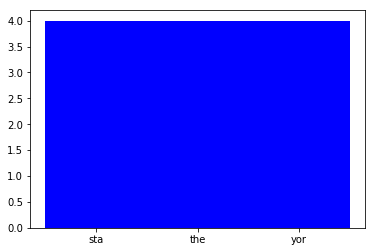

Percentage of Spelling errors similar
15.637860082304528


In [213]:
a=0
g=act()
for i in range(0,209):
    a=a+len([error['old_text'] for error in data[i]['markup'] if error['type'] == 'spelling'])
print("Percentage of Spelling errors similar")
if g!=0:
    print(g*100/a)
else:
    print("No spelling errors found")